In [11]:
# Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [12]:
url = 'https://raw.githubusercontent.com/CarlosSanchez03/Fisica-computacional1/main/Actividad1/diario%20durango.txt'
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Analizaremos los datos de Información Estadística Climatológica del Servico Meteorológico Nacional 
# de CONAGUA que podemos descargar del sitio:
# (https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica) 

# Tomar la dirección URL del archivo en formato 'raw'


# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15527 entries, 1941-01-01 to 2000-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  15464 non-null  float64
 1   Evap    13129 non-null  float64
 2   Tmax    15260 non-null  float64
 3   Tmin    15260 non-null  float64
 4   Año     15527 non-null  int64  
 5   Mes     15527 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 849.1+ KB


In [13]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [31]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1992-01', '1997-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1994-03-01,0.0,0.6,23.0,9.0,1994,Mar
1994-03-02,0.0,8.7,20.0,8.5,1994,Mar
1994-03-03,0.0,6.1,25.0,5.5,1994,Mar
1994-03-04,0.0,7.1,24.0,6.0,1994,Mar
1994-03-05,0.0,7.6,24.0,8.0,1994,Mar


In [32]:
ts_90['Tmax'].head()

Fecha
1994-03-01    23.0
1994-03-02    20.0
1994-03-03    25.0
1994-03-04    24.0
1994-03-05    24.0
Name: Tmax, dtype: float64

In [33]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmax'].copy()

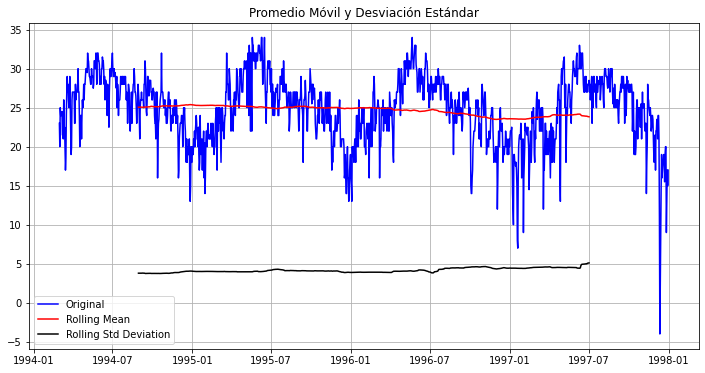

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.146988
p-value                           0.023266
#Lags Used                       13.000000
Number of Observations Used    1388.000000
Critical Value (1%)              -3.435070
Critical Value (5%)              -2.863625
Critical Value (10%)             -2.567880
dtype: float64


In [34]:
test_stationarity(ts_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


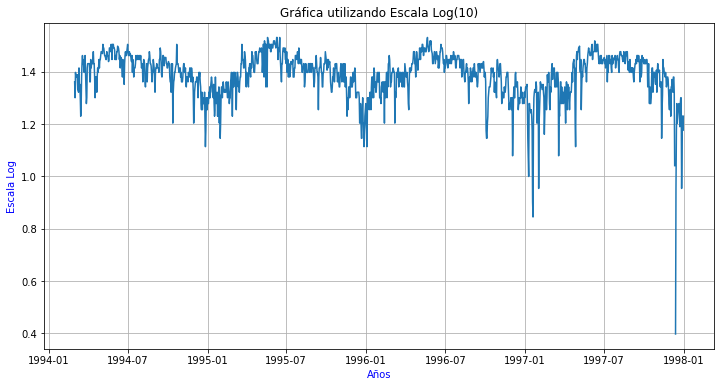

In [51]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

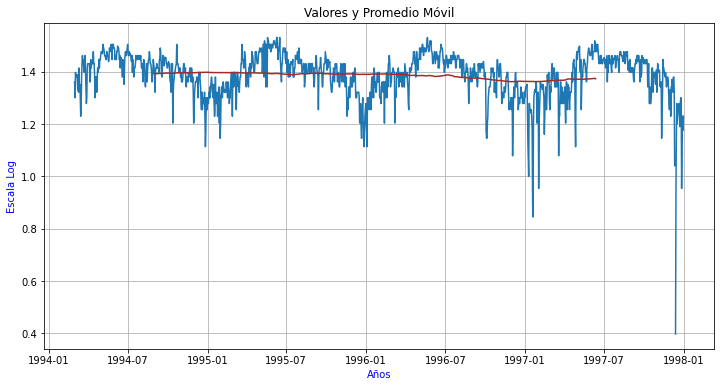

In [52]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [53]:

ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1994-03-01   NaN
1994-03-02   NaN
1994-03-03   NaN
1994-03-04   NaN
1994-03-05   NaN
Name: Tmax, dtype: float64

In [54]:

ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1994-08-30    0.037732
1994-08-31    0.021242
1994-09-01   -0.022776
1994-09-02   -0.071625
1994-09-03    0.004146
Name: Tmax, dtype: float64

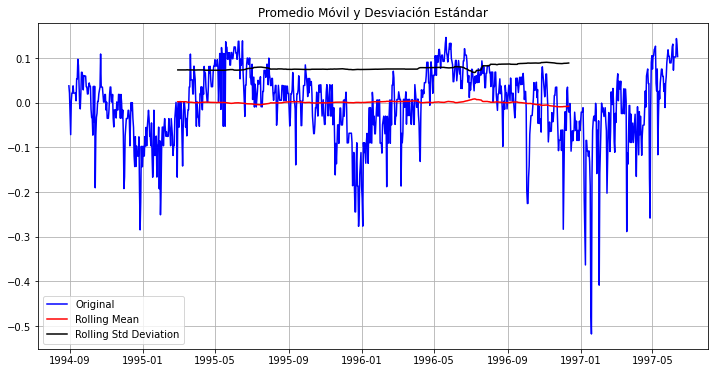

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.034081
p-value                           0.031832
#Lags Used                       15.000000
Number of Observations Used    1002.000000
Critical Value (1%)              -3.436893
Critical Value (5%)              -2.864429
Critical Value (10%)             -2.568308
dtype: float64


In [55]:
test_stationarity(ts_test_log_moving_ave_diff)

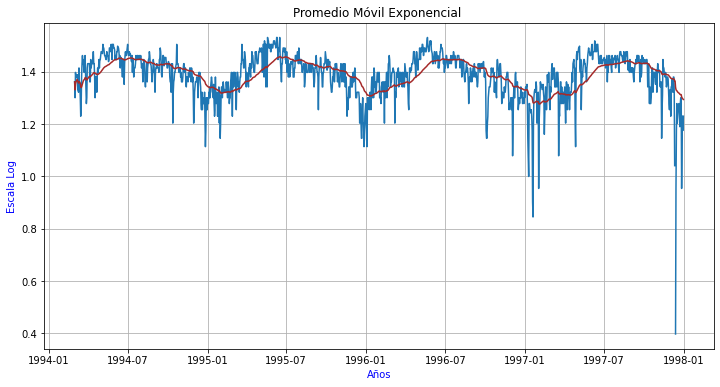

In [56]:
EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [57]:
EWM_avg.head()

Fecha
1994-03-01    1.361728
1994-03-02    1.331028
1994-03-03    1.353849
1994-03-04    1.360670
1994-03-05    1.364761
Name: Tmax, dtype: float64

In [76]:
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

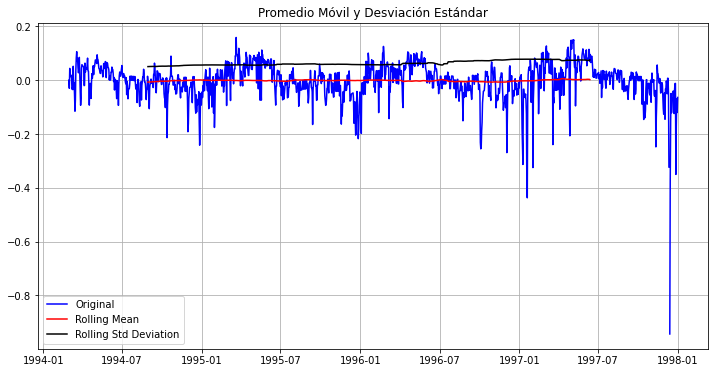

Resultados de la Prueba de Dickey-Fuller:


MissingDataError: ignored

In [77]:
test_stationarity(ts_test_log_EWM_avg_diff)


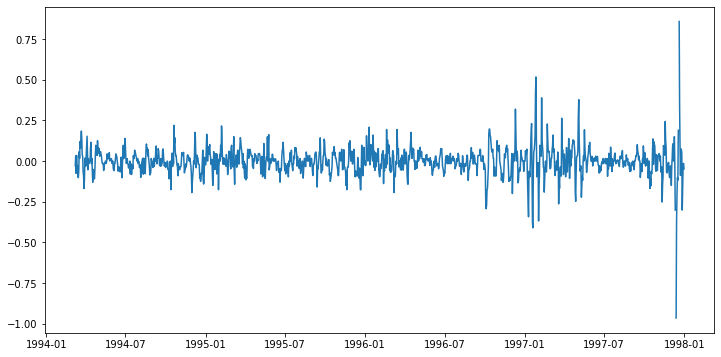

In [61]:
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

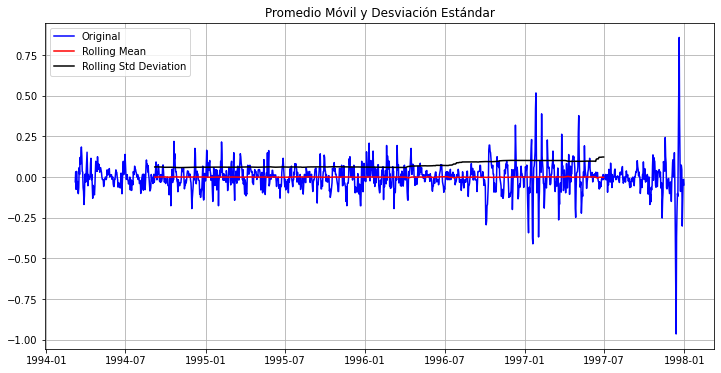

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.074573e+01
p-value                        2.744981e-19
#Lags Used                     1.500000e+01
Number of Observations Used    1.377000e+03
Critical Value (1%)           -3.435108e+00
Critical Value (5%)           -2.863641e+00
Critical Value (10%)          -2.567889e+00
dtype: float64


In [62]:
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [63]:
len(ts_test_log_diff)

1393

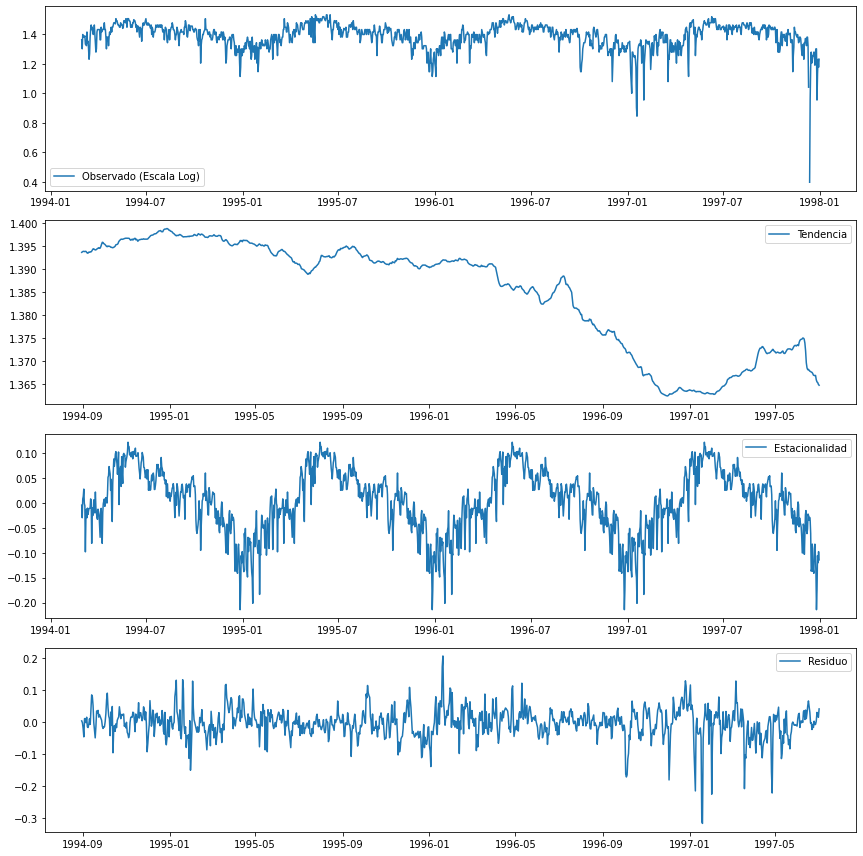

In [64]:
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

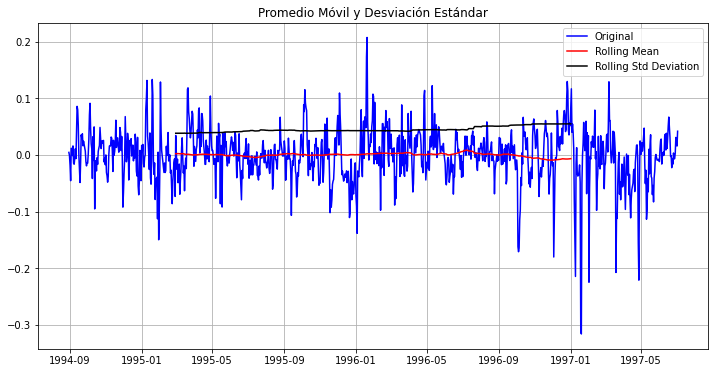

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.383957e+00
p-value                        8.330992e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.023000e+03
Critical Value (1%)           -3.436758e+00
Critical Value (5%)           -2.864369e+00
Critical Value (10%)          -2.568276e+00
dtype: float64


In [65]:
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

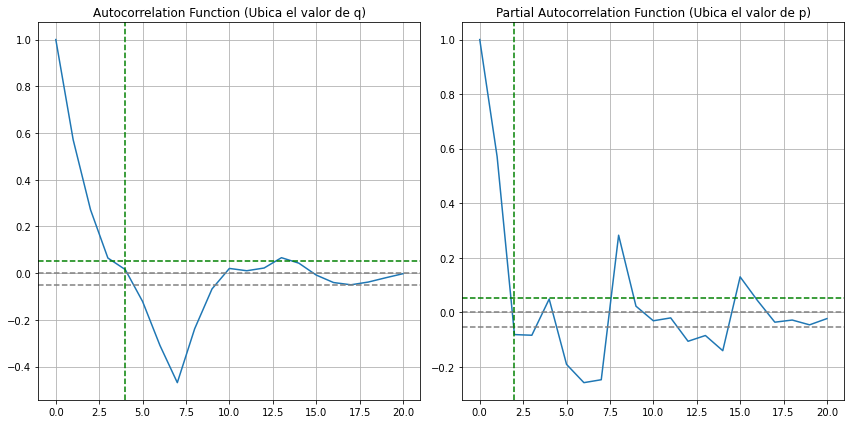

In [66]:
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1400
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2116.945
Method:                       css-mle   S.D. of innovations              0.053
Date:                Sun, 21 Feb 2021   AIC                          -4225.890
Time:                        03:14:40   BIC                          -4204.914
Sample:                             1   HQIC                         -4218.049
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.653e-05      0.001     -0.094      0.925      -0.002       0.002
ar.L1.D.Tmax    -0.2065      0.026     -7.853      0.000      -0.258      -0.155
ar.L2.D.Tmax    -0.1809      0.026     -6.87

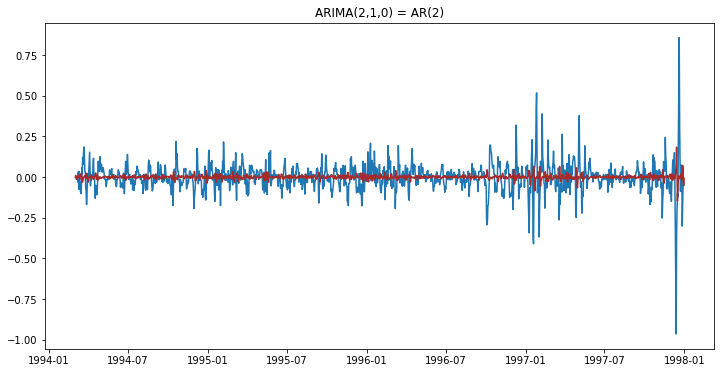

In [67]:
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1400
Model:                 ARIMA(0, 1, 4)   Log Likelihood                2203.926
Method:                       css-mle   S.D. of innovations              0.050
Date:                Sun, 21 Feb 2021   AIC                          -4395.853
Time:                        03:15:02   BIC                          -4364.387
Sample:                             1   HQIC                         -4384.090
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0001      0.000     -0.440      0.660      -0.001       0.000
ma.L1.D.Tmax    -0.3408      0.027    -12.809      0.000      -0.393      -0.289
ma.L2.D.Tmax    -0.2543      0.027     -9.29

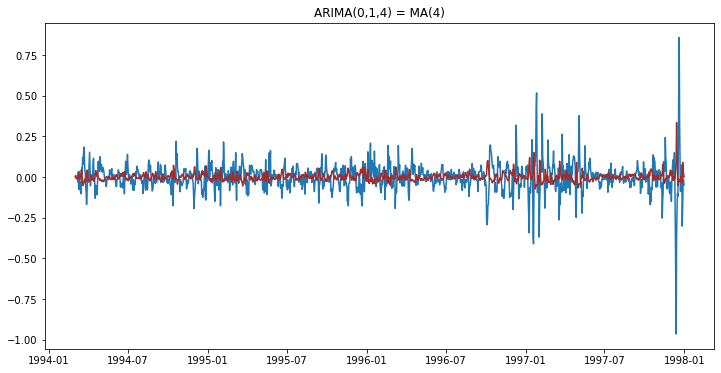

In [68]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1400
Model:                 ARIMA(2, 1, 4)   Log Likelihood                2205.269
Method:                       css-mle   S.D. of innovations              0.050
Date:                Sun, 21 Feb 2021   AIC                          -4394.539
Time:                        03:15:26   BIC                          -4352.585
Sample:                             1   HQIC                         -4378.856
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0001      0.000     -0.454      0.650      -0.001       0.000
ar.L1.D.Tmax     0.1241      0.441      0.281      0.779      -0.741       0.989
ar.L2.D.Tmax     0.1707      0.127      1.33

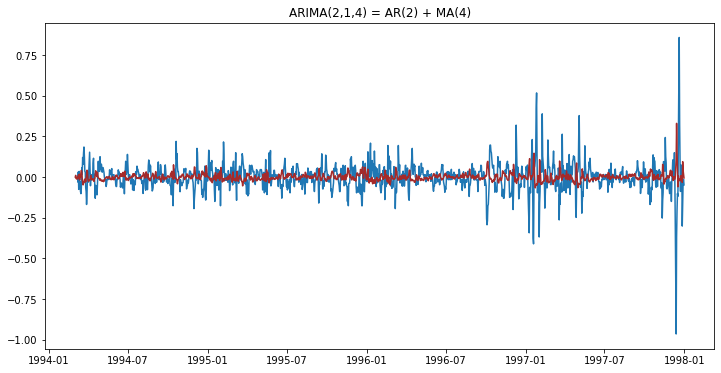

In [69]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [70]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1994-03-02   -0.000111
1994-03-03    0.010439
1994-03-04   -0.009140
1994-03-05   -0.004338
1994-03-06   -0.013005
                ...   
1997-12-27   -0.032831
1997-12-28    0.094658
1997-12-29    0.041826
1997-12-30    0.016902
1997-12-31   -0.005690
Length: 1400, dtype: float64


In [71]:
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1994-03-01         NaN
1994-03-02    1.300919
1994-03-03    1.408379
1994-03-04    1.371071
1994-03-05    1.375873
dtype: float64
Fecha
1997-12-27    0.921412
1997-12-28    1.224992
1997-12-29    1.272275
1997-12-30    1.192993
1997-12-31    1.224759
dtype: float64


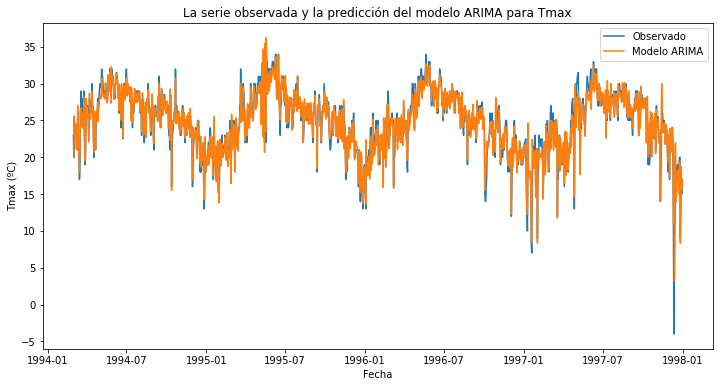

In [72]:
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [73]:
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 1.1108642473655377


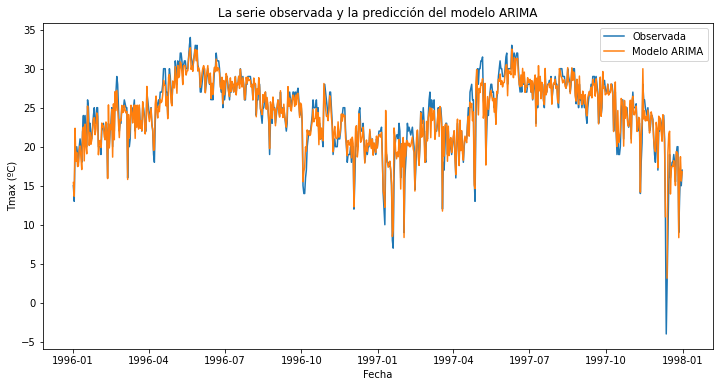

In [74]:
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');